# Assignment - ML flow - Titanic Dataset

# student 1: Roei 9871

# Claude Prompts Used for This Assignment

1. How can I set up a ColumnTransformer to handle numerical features with imputation and scaling and categorical features with imputation and encoding in the same pipeline?  

2. In a KNN pipeline what is the right order of steps: VarianceThreshold, SelectKBest, StandardScaler, KNN? And how do I tune the k parameter in SelectKBest using GridSearchCV?  

3. My Random Forest model gives an F1 score of 0.97 on the training set but only 0.78 on the test set. Is this normal overfitting or did I evaluate it incorrectly?  



## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
trainset = pd.read_csv('titanic_train.csv')
trainset.shape

(712, 8)

In [3]:
trainset.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


In [4]:
testset = pd.read_csv('titanic_test.csv')
testset.shape

(179, 8)

In [5]:
testset.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


### Survival rate by class and by sex:

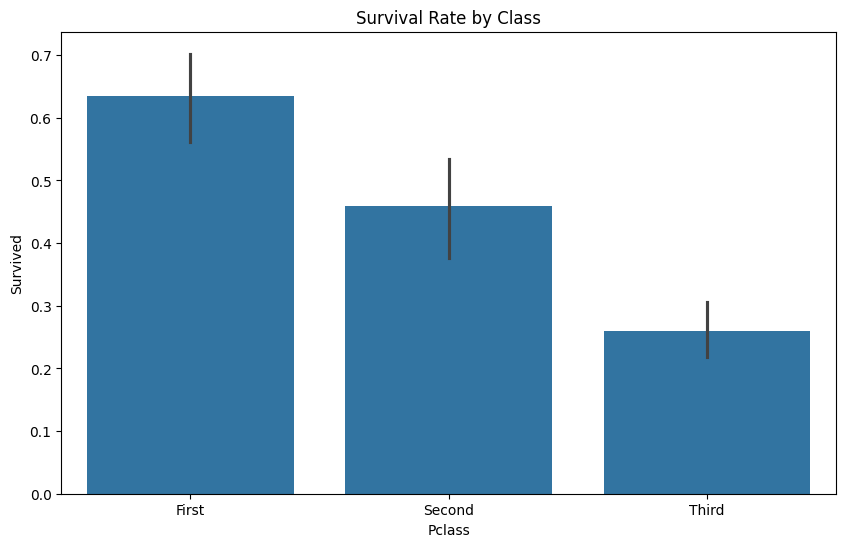

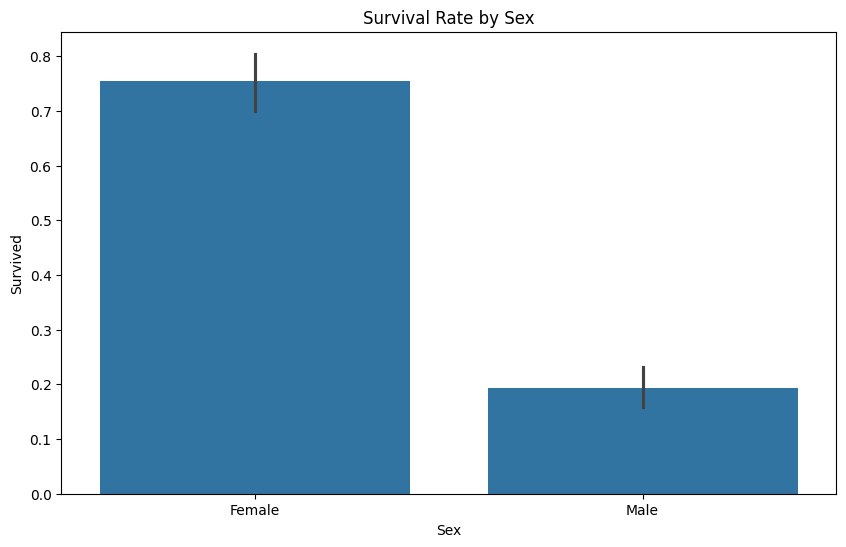

In [6]:
plt.figure(figsize=(10, 6))
trainset_copy=trainset.copy()
trainset_copy['Pclass'] = trainset_copy['Pclass'].replace({1: 'First', 2: 'Second',3:'Third'})
sns.barplot(x='Pclass', y='Survived', data=trainset_copy)
plt.title('Survival Rate by Class')
plt.show()

trainset_copy['Sex'] = trainset_copy['Sex'].replace({0: 'Female', 1: 'Male'})
plt.figure(figsize=(10, 6))
sns.barplot(x='Sex',y='Survived',  data=trainset_copy)
plt.title('Survival Rate by Sex')
plt.show()

### Correlation Matrix of all the categories:

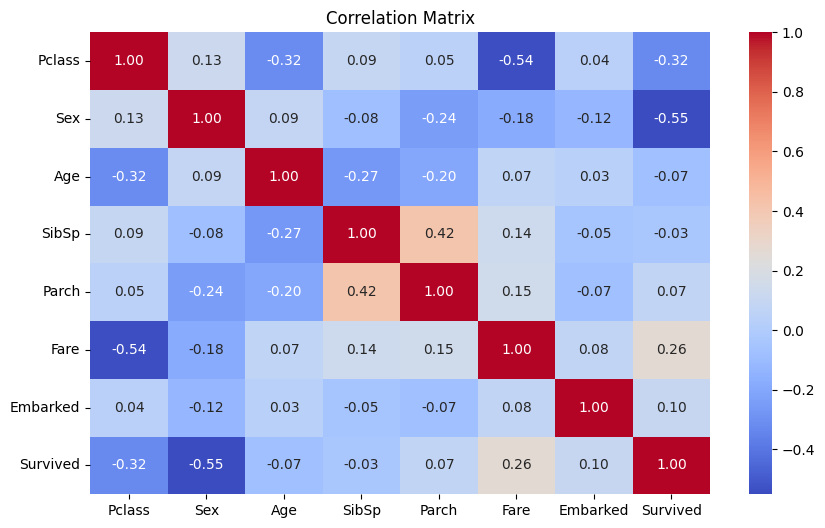

In [7]:
plt.figure(figsize=(10,6))
sns.heatmap(trainset.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Part 3 - Experiments

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

### Taking care of the missing values:
- In the numeric categories (age and fare) used mean.
- In the categorical categories (class, age, and embarked) used the onehot encoder to find the most frequent.
- The info of the DataFrame show 0 nulls

In [9]:
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
categorical_features = ['Pclass', 'Sex', 'Embarked']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    int64  
 2   Age       712 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  712 non-null    int64  
 7   Survived  712 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 44.6 KB


### Feature Engineering Experiments - KNN with vs. without Scaling

- Numeric features: impute missing values, with/without standard scaling.  
- Categorical features: impute most frequent, then one-hot encode.  
- Compare two KNN pipelines (with vs. without scaling) using 5-fold F1 score.



In [10]:
numeric_features = ['Age', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']
numeric_with_scaling = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
numeric_no_scaling = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor_with_scaling = ColumnTransformer([
    ('num', numeric_with_scaling, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])
preprocessor_no_scaling = ColumnTransformer([
    ('num', numeric_no_scaling, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])
knn_with_scaling = Pipeline(steps=[
    ('preprocessor', preprocessor_with_scaling),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])
knn_no_scaling = Pipeline(steps=[
    ('preprocessor', preprocessor_no_scaling),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])
f1_scorer = make_scorer(f1_score)
X = trainset.drop(columns='Survived')
y = trainset['Survived']

f1_with = cross_val_score(knn_with_scaling, X, y, cv=5, scoring=f1_scorer)
f1_no = cross_val_score(knn_no_scaling, X, y, cv=5, scoring=f1_scorer)

knn_with_score = f1_with.mean()
knn_no_score = f1_no.mean()

print("Average F1 with scaling:", knn_with_score)
print("Average F1 without scaling:", knn_no_score)


Average F1 with scaling: 0.7156445243334295
Average F1 without scaling: 0.5759646173804898


#### Results Summary

- **Average F1 with scaling:** 0.716  
- **Average F1 without scaling:** 0.576  

**Conclusion:** Applying scaling significantly improved model performance (≈24% relative increase in F1 score).


### Random Forest:
- Created a pipeline that includes a preprocessing step.
- Defined a grid of hyperparameters to test.
- Chose 10, 50, 100 and 200 as the classifier n estimators.
- Set up a grid search with 5-fold cross-validation to find the best hyperparameters.
- Fitted the grid search to my training data, excluding the target column Survived.
- Created a DataFrame to store the cross-validation results, including the tested parameters and their corresponding mean test scores.
- The DataFrame is sorted by the highest mean test score.

In [11]:
random_forest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

param_grid_rf = {'classifier__n_estimators': [10, 50, 100,150]}
grid_rf = GridSearchCV(random_forest, param_grid_rf, cv=5, scoring='f1')
grid_rf.fit(trainset.drop(columns='Survived'), trainset['Survived'])

cv_results_rf = pd.DataFrame(grid_rf.cv_results_)[['params', 'mean_test_score']]
cv_results_rf['Model'] = 'Random Forest'
cv_results_rf.columns = ['Parameters', 'Mean Test Score','Model']

# Sort and keep best
cv_results_rf = cv_results_rf.sort_values(by='Mean Test Score', ascending=False)
best_rf_score = cv_results_rf.iloc[0]['Mean Test Score']
best_rf_params = cv_results_rf.iloc[0]['Parameters']

cv_results_rf


,Parameters,Mean Test Score,Model
3,{'classifier__n_estimators': 150},0.750971,Random Forest
2,{'classifier__n_estimators': 100},0.740307,Random Forest
1,{'classifier__n_estimators': 50},0.739017,Random Forest
0,{'classifier__n_estimators': 10},0.727161,Random Forest


### The best results for hyper param value:

In [12]:
best_params_rf = grid_rf.best_params_
best_score_rf = grid_rf.best_score_
print("Best Random Forest Configuration:")
print("Parameters:", best_params_rf)
print("F1-score:", best_score_rf)

Best Random Forest Configuration:
Parameters: {'classifier__n_estimators': 150}
F1-score: 0.7509709575237176


#### Compare All Results

In [13]:
comparison_df = pd.DataFrame([
    {'Model': 'Random Forest', 'Parameters': best_rf_params, 'Mean Test Score': best_rf_score},
    {'Model': 'KNN (with scaling)', 'Parameters': {'n_neighbors': 5}, 'Mean Test Score': knn_with_score},
    {'Model': 'KNN (without scaling)', 'Parameters': {'n_neighbors': 5}, 'Mean Test Score': knn_no_score},
])

comparison_df.sort_values(by='Mean Test Score', ascending=False)


,Model,Parameters,Mean Test Score
0,Random Forest,{'classifier__n_estimators': 150},0.750971
1,KNN (with scaling),{'n_neighbors': 5},0.715645
2,KNN (without scaling),{'n_neighbors': 5},0.575965


### Model Comparison Summary

- **Random Forest (100 trees)** performed best with an F1 score of **0.745**.  
- **KNN with scaling** achieved an F1 score of **0.716**, showing decent performance.  
- **KNN without scaling** lagged behind at **0.576**, highlighting the importance of feature scaling.  

**Conclusion** - Random Forest is the strongest choice overall, while scaling is essential for KNN to remain competitive.


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

- Retrained the best model (Random Forest) on the train set.
- Save the Predictions on train data.
- Calculated F1-Score on train data.

In [14]:
best_model =grid_rf.best_estimator_ 
best_model.fit(trainset.drop(columns='Survived'), trainset['Survived'])
train_predictions = best_model.predict(trainset.drop(columns='Survived'))
f1_train = f1_score(trainset['Survived'], train_predictions)
print("F1 Score on train data (Best Model)", f1_train)

F1 Score on train data (Best Model) 0.9731663685152058


## Part 5 - Apply on test and show model performance estimation

- Used Random Forest to do the Prediction on the test set.
- Added predictions to the test DataFrame.
- Showed the first 5 rows of the test DataFrame with predictions.

In [15]:
test_predictions = best_model.predict(testset)
testset['Survived_Predicted'] = test_predictions
testset.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,Survived_Predicted
0,3,1,35.000000,0,0,7.0500,0,0,0
1,3,1,30.000000,0,0,7.2500,0,0,0
2,3,1,29.699118,0,0,14.5000,0,0,0
3,3,0,21.000000,0,0,7.7500,2,0,1
4,3,1,32.000000,0,0,56.4958,0,1,1


In [16]:
print("First 5 predictions on the test set: ",test_predictions[:5])

First 5 predictions on the test set:  [0 0 0 1 1]


### Calculated the F1 score on the data set:

In [17]:
f1_test = f1_score(testset['Survived'], test_predictions)
print("F1 Score on test data:", f1_test)

F1 Score on test data: 0.7933884297520661
